# Synthetic Glacier: Preprocessing

Lets extract some data along an extended flowline for our Synthetic Glacier. Information we will extract:  
  * Surface profile from SRTM DEM,  
  * Bedrock profile from Faranotti et al. 2019

In [1]:
import os
import numpy as np
import geopandas as gpd
import contextily as ctx
import cartopy.crs as ccrs

import pickle 
import scipy.signal as signal
from scipy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import fiona
import rasterio
import rasterio.mask
from rasterio.io import MemoryFile
from rasterio.transform import Affine

plt.rcParams['text.usetex'] = True

In [2]:
def centerline_2_points(geom, dx=30):
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    num_vert = int(round(geom.length / dx))
    if num_vert == 0: 
        num_vert = 1
    multipoint = [geom.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)] 
    Latx = [multipoint[i].x for i in range(len(multipoint))]
    Laty = [multipoint[i].y for i in range(len(multipoint))]
    gdf  = gpd.GeoDataFrame(geometry=gpd.points_from_xy(Latx,Laty))
    return gdf

def lstq(x,y,order):
    A     = np.vstack([x**i for i in range(0,order)]).T
    coefs = LA.lstsq(A,y)[0]
    return coefs

In [3]:
EB_2007_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/EB/dem_2007.tif'
BED_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_BDEM.tif'
SRTM_fp    = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/SRTM/AST_merge/ASTGTMV003_MERGED_UTM7N.tif'
GC_Surf_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/surface_DEM_RGI60-01.16198.tif'

# Alternative Version of the Bed (05/12/2021)

In [4]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'

# What tributary are we looking at?
SURGE_TRIB = True

if SURGE_TRIB:
    #FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')
    FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N_extended.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL[LK_FL['MAIN'] == 1], dx=10)
    # For whatever reason we need to flip the oggm flowline
    LK_CP = LK_CP.sort_index(axis=0,ascending=False).reset_index(drop=True)
else:
    FL_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL, dx=10)

LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]

In [5]:
with rasterio.open(EB_2007_fp) as src:
    LK_CP['EB_2007'] = [x for x in src.sample(prof_coords)]
    LK_CP['EB_2007'] = LK_CP.apply(lambda x: x['EB_2007'][0], axis=1)

with rasterio.open(SRTM_fp) as src:
    LK_CP['SRTM'] = [x for x in src.sample(prof_coords)]
    LK_CP['SRTM'] = LK_CP.apply(lambda x: x['SRTM'][0], axis=1)

with rasterio.open(GC_Surf_fp) as src:
    LK_CP['GC_Surf'] = [x for x in src.sample(prof_coords)]
    LK_CP['GC_Surf'] = LK_CP.apply(lambda x: x['GC_Surf'][0], axis=1)
    
with rasterio.open(BED_DEM_fp) as src:
    bed_nodata = src.nodata
    LK_CP['bedprof'] = [x for x in src.sample(prof_coords)]
    LK_CP['bedprof'] = LK_CP.apply(lambda x: x['bedprof'][0], axis=1)

# with rasterio.open(THIC_DEM_fp) as src:
#     LK_CP['thickness'] = [x for x in src.sample(prof_coords)]
#     LK_CP['thickness'] = LK_CP.apply(lambda x: x['thickness'][0], axis=1)

# Replace nodata with np.nan
LK_CP = LK_CP.replace([-9999.0, 0.0, bed_nodata],np.nan)


In [6]:
# x-coordinate in km 
x_dx10 = LK_CP.index.to_numpy() * 10.0 / 1000.0

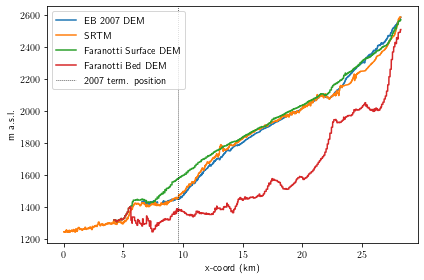

In [7]:
fig, ax = plt.subplots()

ax.plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax.plot(x_dx10, LK_CP['SRTM']   , label='SRTM')
ax.plot(x_dx10, LK_CP['GC_Surf'], label='Faranotti Surface DEM')
ax.plot(x_dx10, LK_CP['bedprof'], label='Faranotti Bed DEM')

ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

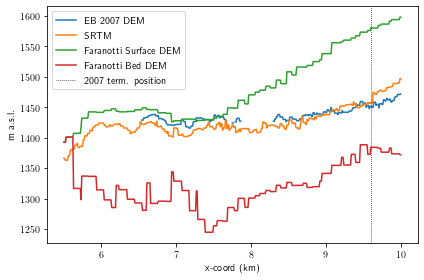

In [8]:
fig, ax = plt.subplots()

ax.plot(x_dx10[550:1001], LK_CP['EB_2007'][550:1001], label='EB 2007 DEM')
ax.plot(x_dx10[550:1001], LK_CP['SRTM'][550:1001]   , label='SRTM')
ax.plot(x_dx10[550:1001], LK_CP['GC_Surf'][550:1001], label='Faranotti Surface DEM')
ax.plot(x_dx10[550:1001], LK_CP['bedprof'][550:1001], label='Faranotti Bed DEM')

ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (km)')


ax.axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

In [9]:
ss_poly   = np.polyval( np.polyfit(x_dx10, LK_CP['SRTM'], 10), x_dx10)
ss_smooth = signal.savgol_filter( x=LK_CP['SRTM'],   window_length=211, polyorder=5)
bb_smooth = signal.savgol_filter( x=LK_CP['bedprof'],window_length=211, polyorder=5)

correction = np.mean(ss_smooth[550:1001] - bb_smooth[550:1001])

In [10]:
ss_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], ss_poly[x_dx10 > 9.0]])
bb_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], (bb_smooth + correction)[x_dx10 > 9.0]])

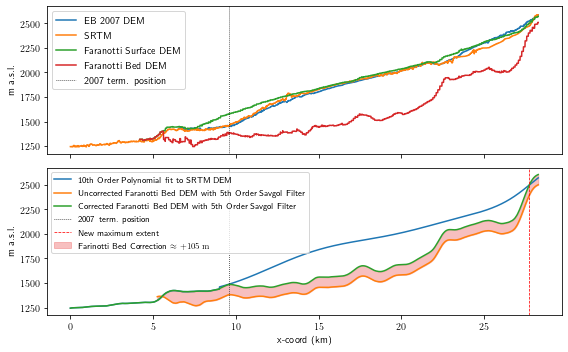

In [11]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

ax[0].plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax[0].plot(x_dx10, LK_CP['SRTM']   , label='SRTM')
ax[0].plot(x_dx10, LK_CP['GC_Surf'], label='Faranotti Surface DEM')
ax[0].plot(x_dx10, LK_CP['bedprof'], label='Faranotti Bed DEM')

ax[0].set_ylabel('m a.s.l.')

ax[0].axvline(9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax[0].legend()

ax[1].plot(x_dx10, ss_prop, label='10th Order Polynomial fit to SRTM DEM')
ax[1].plot(x_dx10, bb_smooth,label='Uncorrected Faranotti Bed DEM with 5th Order Savgol Filter')
ax[1].plot(x_dx10, bb_prop, label='Corrected Faranotti Bed DEM with 5th Order Savgol Filter')
ax[1].fill_between(x_dx10, 
                 bb_smooth, bb_prop, 
                 color='lightcoral', alpha=0.5, 
                 label=r'Farinotti Bed Correction $\approx + 105 \; \rm{m}$')

# np.concatenate([ss_smooth[x_coord < 9.0], (bb + correction)[x_coord >= 9.0]])
ax[1].set_ylabel('m a.s.l.')
ax[1].set_xlabel('x-coord (km)')

ax[1].axvline(9.6,  label='2007 term. position', c='k', ls=':', lw=0.75)
ax[1].axvline(27.7, label='New maximum extent',  c='r', ls='--', lw=0.75)

ax[1].legend(fontsize='small')

plt.tight_layout()

fig.savefig('/Users/andrewnolan/Desktop/lilklu.png',dpi=600,bbox_inches='tight',facecolor='w')

In [12]:
xx  = np.linspace(x_dx10.min()*1e3,x_dx10.max()*1e3,x_dx10.shape[0])

# Chop off the upper portion where ice-thickness would be zero
ss_new = ss_prop[:2770]
bb_new = bb_prop[:2770]
xx_new = xx[:2770]


np.savetxt('../Data/Topography/REF_BedTopo.dat'   , np.array([xx_new,bb_new]).T,fmt='%.3e')
np.savetxt('../Data/Topography/REF_SurfTopo.dat'  , np.array([xx_new,ss_new]).T,fmt='%.3e')